In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy as sp
import statistics
from sklearn import set_config
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             median_absolute_error,
                             max_error, make_scorer
                            )
from sklearn.metrics import PredictionErrorDisplay
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset,linear_rainbow
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats 
set_config(display="diagram", print_changed_only=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Metriques de performances

In [2]:
def get_performances(real_value, estimated_value, metrics):
    perfs = []
    for metric_func in metrics:
        perfs.append((metric_func.__name__, metric_func(real_value, estimated_value)))
    return pd.DataFrame(perfs, columns=["metric", "value"])


def get_all_performances(value_train, values_test, metrics):
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)

In [3]:
METRICS = [r2_score,
           mean_squared_error,
           median_absolute_error,
           max_error
          ]

In [4]:
def rmse(x,y):
    rmse= np.sqrt(mean_squared_error(x,y))
    return rmse

### Pipeline de modélisation

In [5]:
def model(estimateur,normaliseur):
    model = Pipeline(
        steps=[ ("normaliseur", normaliseur), ("regressor", estimateur)]
    )

    return model

In [6]:
data = gpd.read_file('df_velo.geojson')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [7]:
data.sample(n=12)

nom_com insee_com  longueur  longueur_pond_hw  \
919         Vert-le-Petit     91649      4002           3726.50   
41    Armentières-en-Brie     77008        87             43.50   
871    Thorigny-sur-Marne     77464      9390           9685.50   
548    Marnes-la-Coquette     92047     10349          11017.00   
914  Verrières-le-Buisson     91645     51095          50127.00   
507                Lognes     77258     21091          20345.50   
192       Chaumes-en-Brie     77107      1164           1201.00   
539      Mareil-en-France     95365      5696           5097.25   
209        Choisy-en-Brie     77116       286            286.00   
485          Les Molières     91411      5557           5337.25   
600    Montigny-sur-Loing     77312      1421           1421.00   
848              Soindres     78597      7075           7507.75   

     longueur_pond_adg  difference_hw  difference_adg  cap_com  stat_com  \
919            3476.75        -275.50         -525.25      NaN       NaN   
41               87.00         -43.50            0.00      NaN       NaN   
871           10150.25         295.50          760.25      NaN       NaN   
548           11383.00         668.00         1034.00      NaN       NaN   
914           50931.25        -968.00         -163.75      NaN       NaN   
507           23995.00        -745.50         2904.00      NaN       NaN   
192            1438.00          37.00          274.00      NaN       NaN   
539            6605.75        -598.75          909.75      NaN       NaN   
209             286.00           0.00            0.00      NaN       NaN   
485            5912.50        -219.75          355.50      NaN       NaN   
600            1435.50           0.00           14.50      NaN       NaN   
848            7075.00         432.75            0.00      NaN       NaN   

                               source       surface  population  \
919  IGN:EXPRESS-COG-CARTO-TERRITOIRE  6.844038e+06        2818   
41   IGN:EXPRESS-COG-CARTO-TERRITOIRE  7.206222e+06        1225   
871  IGN:EXPRESS-COG-CARTO-TERRITOIRE  5.135560e+06       10454   
548  IGN:EXPRESS-COG-CARTO-TERRITOIRE  3.476341e+06        1774   
914  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.000280e+07       14888   
507  IGN:EXPRESS-COG-CARTO-TERRITOIRE  3.998799e+06       14353   
192  IGN:EXPRESS-COG-CARTO-TERRITOIRE  2.003419e+07        3339   
539  IGN:EXPRESS-COG-CARTO-TERRITOIRE  6.990417e+06         707   
209  IGN:EXPRESS-COG-CARTO-TERRITOIRE  2.513427e+07        1308   
485  IGN:EXPRESS-COG-CARTO-TERRITOIRE  7.037893e+06        1874   
600  IGN:EXPRESS-COG-CARTO-TERRITOIRE  9.186413e+06        2660   
848  IGN:EXPRESS-COG-CARTO-TERRITOIRE  5.233194e+06         685   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [8]:
data.describe()

,longueur,longueur_pond_hw,longueur_pond_adg,difference_hw,difference_adg,cap_com,stat_com,surface,population
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,82.000000,82.000000,1.005000e+03,1005.000000
mean,14104.276617,13958.353731,14310.651244,-145.922886,206.374627,556.780488,17.951220,8.955252e+06,12040.500498
std,24139.660522,23629.009724,23513.063958,1425.025097,2915.169853,713.441408,21.245713,8.147897e+06,23891.323510
min,2.000000,2.500000,2.500000,-12902.000000,-22854.000000,0.000000,1.000000,9.722876e+04,50.000000
25%,1476.000000,1466.250000,1643.250000,-273.500000,0.000000,120.500000,4.000000,4.481700e+06,850.000000
50%,5293.000000,5337.000000,5725.000000,-8.750000,155.000000,236.000000,8.000000,7.343944e+06,2699.000000
75%,15626.000000,15930.250000,16379.250000,165.500000,870.500000,709.000000,22.750000,1.135592e+07,12266.000000
max,228240.000000,226273.250000,231651.000000,15562.250000,20850.500000,3345.000000,90.000000,1.722864e+08,230981.000000


Les variables nom_com, insee_com, source et geometry ne serons pas utilisées pour la modélisation

In [9]:
base= data[['longueur','longueur_pond_hw','longueur_pond_adg','difference_hw','difference_adg','cap_com','stat_com','surface','population']]

In [10]:
# from pynsee.download import download_file
# filosofi = download_file("FILOSOFI_COM_2016")

Les station vélib ne sont pas présentes dans toutes les communes équipées d'une piste cyclables, ce qui justifie la préence de valeurs manquantes pour les variables cap_com et stat_com. 2tant en présence de variables numériques positives, ces valeurs manquantes seront imputées par 0. 

In [11]:
base.fillna(0, inplace=True)

/tmp/ipykernel_26863/84762160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base.fillna(0, inplace=True)


In [12]:
base.sample(12)

,longueur,longueur_pond_hw,longueur_pond_adg,difference_hw,difference_adg,cap_com,stat_com,surface,population
296,948,954.50,948.00,6.50,0.00,0.0,0.0,4.361258e+06,183
940,27170,26911.50,31875.75,-258.50,4705.75,0.0,0.0,8.077006e+06,34890
711,2031,1878.75,2133.00,-152.25,102.00,0.0,0.0,1.019092e+07,3923
717,516,472.00,516.00,-44.00,0.00,0.0,0.0,5.121570e+06,289
416,38475,38059.00,38561.00,-416.00,86.00,0.0,0.0,5.842759e+06,20692
60,10839,10515.25,10663.25,-323.75,-175.75,0.0,0.0,1.279680e+07,6813
67,8728,8184.25,9833.00,-543.75,1105.00,0.0,0.0,8.034883e+06,1899
773,149102,164664.25,169952.50,15562.25,20850.50,0.0,0.0,5.313401e+07,44806
899,5701,7126.25,7126.25,1425.25,1425.25,0.0,0.0,8.034579e+06,2032
157,1516,1347.50,1647.50,-168.50,131.50,0.0,0.0,8.619366e+06,2482


In [13]:
base['log_long']= np.log(base['longueur'])
base['log_lph']=np.log(base['longueur_pond_hw'])
base['log_lpadg']=np.log(base['longueur_pond_adg'])
base['long_surf'] = base['longueur' ]/base['surface']

/tmp/ipykernel_26863/358026108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['log_long']= np.log(base['longueur'])
/tmp/ipykernel_26863/358026108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['log_lph']=np.log(base['longueur_pond_hw'])
/tmp/ipykernel_26863/358026108.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

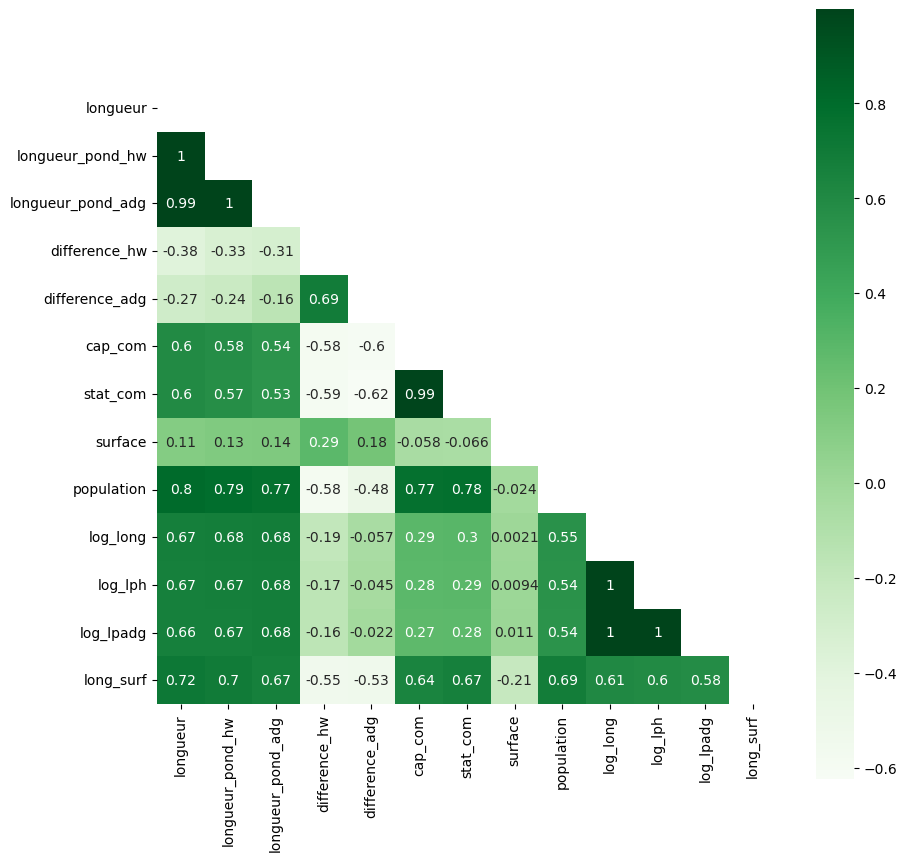

In [14]:
plt.figure(figsize=(10, 10))
corr= base.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(base.corr(), cmap='Greens',square=True, mask=mask, cbar=True, annot=True);

De l'analyse du tableau de corrélation, il ressort que les variables longueur, longueur_pond_hw et longueur_pond_adg sont très fortement correlées entre elles. Elles représentent quasiment la même variable. 
Il en est de même des variables cap_com et stat_com. De ce fait nous ne retiendrns qu'une des variables de chaque relation pour la modélisation

### Modélisation linéaire

In [15]:
Y= base['longueur']

#### Régression linéaire

In [16]:
reg_lin=sm.OLS(Y, sm.add_constant(base[['difference_hw','difference_adg', 'cap_com', 'surface', 'population','long_surf']])).fit()

In [17]:
print(reg_lin.summary())

                            OLS Regression Results                            
Dep. Variable:               longueur   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     565.4
Date:                Sat, 30 Dec 2023   Prob (F-statistic):          6.68e-317
Time:                        11:53:20   Log-Likelihood:                -10823.
No. Observations:                1005   AIC:                         2.166e+04
Df Residuals:                     998   BIC:                         2.169e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5077.4127    651.372     -7.

Il ressort des résultats de la regréssion de la lonqueur des aménagements cyclables sur les variables difference_hw,difference_adg,cap_com, stat_com, surface,population et long_surf que le modèle est globalement significatif (Prob (F-statistic)= 0) avec un pouvoit prédictif de plus de 77%. A l'exception de la variable difference_hw, toutes les autres variables, la constante y compris, sont statistiquement significatives.
A l'exception de la variable stat_com, les effets marginaux des des autres variables sont toutes positives. Autrement dit, une augmentation une d'une personne induit une augmentation de 0.65 mètre d'ménagement cyclable.

Bien que ce modèle semble adapté, sa validation nécessite la réalisation d'une série de tests.

#### Vérification des hypothèses de la régréssion linéaire

In [18]:
# Normalité des résidus 
residus= reg_lin.resid
sw_test = shapiro(residus)
print('Test de Shapiro-Wilk pour la normalité des résidus :', sw_test)

Test de Shapiro-Wilk pour la normalité des résidus : ShapiroResult(statistic=0.7137206196784973, pvalue=2.864162696420052e-38)


Les hypothèses du  test de Shapiro-Wilk utilisé sont :
        - H0 : Les données sont issues d'une distribution normale
        - H1 : Les données ne sont pas issues d'une distribution normale
La valeur de la p_value inférieure 0.05 suggère que les données ne sont pas en accords avec l'hypothèse nulle

In [27]:
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats 
# Autocorrélation des résidus
dw_statistic= durbin_watson(residus)
print(f"Statistique de Durbin-Watson : {dw_statistic}")

Statistique de Durbin-Watson : 1.9333477016151124


Les hypothèses du test d'autocorrélation de Durbin-Watson sont les suitvantes :
    - H0: Les résidus sont non autocorrelés
    - H1: les résidus sont autocorrelés
La valeur de la statistique de test est toujours comprrise entre 0 et 4 et s'interprete comme suit :
    - Une valeur proche de 2 indique une absence d'autocorrélation.
    - Une valeur significativement inférieure à 2 suggère une autocorrélation positive.
    - Une valeur significativement supérieure à 2 suggère une autocorrélation négative.
La valeur de la P value inférieure à 5% montre que la statistique de Durbin Watson obtenue avec nos données n'est pas statistiquement proche de 2. C'est-à-dire que les erreurs sont autocorrelés.
Ce résultat présage une présence d'hétéroscédasticité. 

In [28]:
#Hétéroscédasticité
bp_test = het_breuschpagan(residus, sm.add_constant(base[['difference_hw','difference_adg', 'cap_com','surface', 'population','long_surf']]))
bp_test[1]


1.1940948646581322e-49

Les hypothèses du test sont les suivantes :
    - H0 : la variance des erreurs est constante (homoscédasticité). Cela signifie que la variance de l'erreur est la même pour toutes les observations.
    - H1: L'hypothèse alternative suggère que la variance des erreurs n'est pas constante (hétéroscédasticité). Cela signifie que la variance de l'erreur peut varier parmi les observations.
La valeur de la P_value < 0.05 montre que les données sont en accord avec l'hypothèses H1 de présence d'hétéroscédasticité.  

In [ ]:
Face au problème d'autocorrélation et d'hétéroscédasticité, il existe plusieurs solutions :  
    - Faire une transformation des variables (exemple : prendre le logarithme de la variable d'intérêt)
    - Utiliser de modèles plus robuste ( la régression Ridge, la régréssion Lasso)


In [29]:
reg=model(LinearRegression(),RobustScaler())
reg

Pipeline(memory=None,
         steps=[('normaliseur',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              unit_variance=False, with_centering=True,
                              with_scaling=True)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  positive=False))],
         verbose=False)

In [77]:
X_train, X_test, y_train, y_test = train_test_split( base[['difference_hw','difference_adg', 'cap_com', 'surface', 'population','long_surf']], Y, test_size=0.30, random_state=42)

In [31]:
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

In [32]:
print(f"Model score - training data: {reg.score(X_train, y_train)}")
print(f"Model score - test data: {reg.score(X_test, y_test)}")

Model score - training data: 0.7521516249349444
Model score - test data: 0.7659748455447823


Malgré que le modèle ne soit pas valide au sens économétrique, il semble avoir un bon pouvoir prédictif tant sur les données d'entainement que sur les données de tests.

In [33]:
get_all_performances(value_train=(y_train, y_train_pred),
                     values_test=(y_test, y_test_pred),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,7.521516e-01,7.659748e-01
1,mean_squared_error,1.323279e+08,1.620743e+08
2,median_absolute_error,3.357785e+03,3.191225e+03
3,max_error,1.053005e+05,1.162972e+05


In [34]:
rmse(y_test, y_test_pred)

12730.841286219282

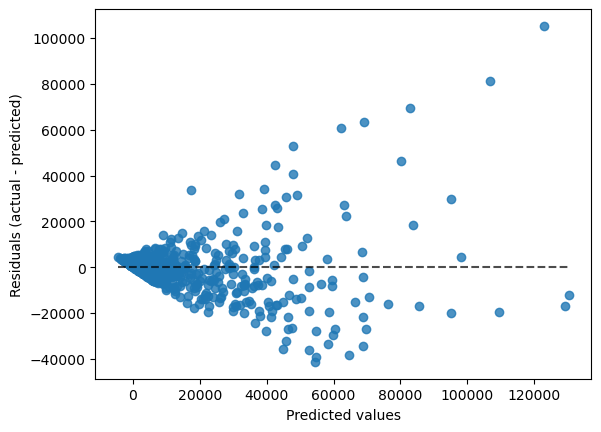

In [35]:
display = PredictionErrorDisplay(y_true=y_train, y_pred=y_train_pred)
display.plot()
plt.show()

In [46]:
coef = reg["regressor"].coef_
model_features=reg.feature_names_in_
df_feature_importance = pd.DataFrame(coef, columns=["coef"], index=model_features)

Text(0.5, 1.0, 'Regression linéaire')

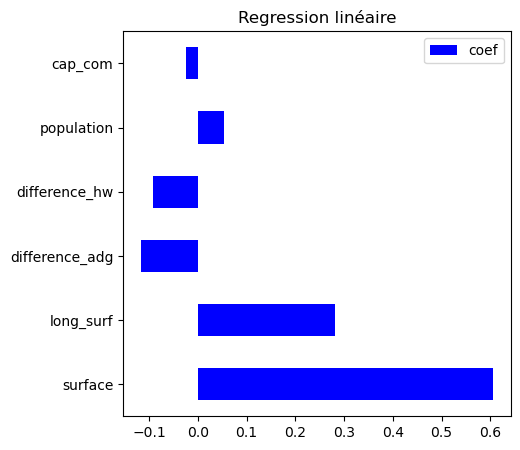

In [69]:
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=False)
 .head(40)
 .plot(kind="barh", figsize=(5, 5), color= 'blue')
)
plt.title("Regression linéaire")

#### Régréssion sur les données transformées

In [79]:

def model_trans(estimateur,normaliseur):
    model_trans = Pipeline(
        steps=[ ("normaliseur", normaliseur), ("Transformateur",TransformedTargetRegressor(
            regressor=estimateur, func=np.log1p, inverse_func=np.expm1
        ) )]
    )

    return model_trans

In [80]:
reg_trans= model_trans(LinearRegression(),RobustScaler())
reg_trans

Pipeline(memory=None,
         steps=[('normaliseur',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              unit_variance=False, with_centering=True,
                              with_scaling=True)),
                ('Transformateur',
                 TransformedTargetRegressor(check_inverse=True,
                                            func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression(copy_X=True,
                                                                       fit_intercept=True,
                                                                       n_jobs=None,
                                                                       positive=False),
                                            transformer=None))],
         verbose=False)

In [81]:
reg_trans.fit(X_train, y_train)
y_test_predt = reg_trans.predict(X_test)
y_train_predt = reg_trans.predict(X_train)

In [82]:
print(f"Model score - training data: {reg_trans.score(X_train, y_train)}")
print(f"Model score - test data: {reg_trans.score(X_test, y_test)}")

Model score - training data: -7.141399722829885
Model score - test data: -1361.2006304767924


In [ ]:
Le modèle estimé sur une transformation logarithmique de la variable d'intérêt est inappropriéb pour ce travail.

#### Régression Lasso

La régression lasso fait partie du groupe des modèles linéaires qui intègre un facteur de pénalisation. Le choix optimal de ce fateur permet de construire un modèle consistant.
(Pour une meilleur compréhensiosn, vous pouver vous reférer à sklearn.linear_model.LinearRegression.)

In [ ]:
Evaluons le modèle pour une valeur valeur spécifique alpha= 0.5

In [84]:
reg_lasso= model(Lasso(alpha=0.5),RobustScaler())
reg_lasso

Pipeline(memory=None,
         steps=[('normaliseur',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              unit_variance=False, with_centering=True,
                              with_scaling=True)),
                ('regressor',
                 Lasso(alpha=0.5, copy_X=True, fit_intercept=True,
                       max_iter=1000, positive=False, precompute=False,
                       random_state=None, selection='cyclic', tol=0.0001,
                       warm_start=False))],
         verbose=False)

In [85]:
reg_lasso.fit(X_train, y_train)
y_test_predl = reg_lasso.predict(X_test)
y_train_predl = reg_lasso.predict(X_train)

In [86]:
get_all_performances(value_train=(y_train, y_train_predl),
                     values_test=(y_test, y_test_predl),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,7.521516e-01,7.659776e-01
1,mean_squared_error,1.323279e+08,1.620724e+08
2,median_absolute_error,3.357089e+03,3.190517e+03
3,max_error,1.053014e+05,1.162957e+05


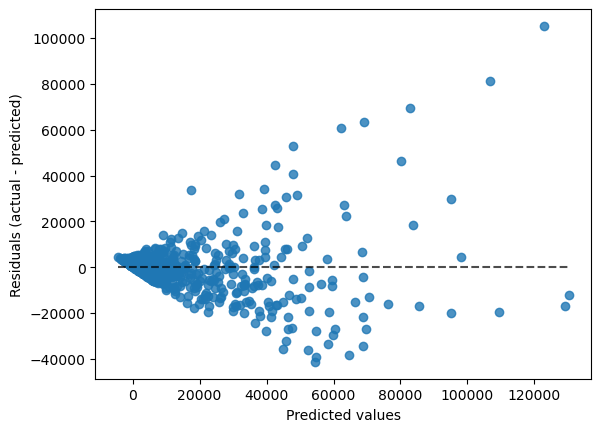

In [87]:
display = PredictionErrorDisplay(y_true=y_train, y_pred=y_train_predl)
display.plot()
plt.show()

La regréssion lasso conduit au même résultat que la régréssion linéaire

#### Regréssion Ridge

In [90]:
reg_ridge= model(RidgeCV(),RobustScaler())
reg_ridge

Pipeline(memory=None,
         steps=[('normaliseur',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              unit_variance=False, with_centering=True,
                              with_scaling=True)),
                ('regressor',
                 RidgeCV(alpha_per_target=False, alphas=(0.1, 1.0, 10.0),
                         cv=None, fit_intercept=True, gcv_mode=None,
                         scoring=None, store_cv_values=False))],
         verbose=False)

In [91]:
reg_ridge.fit(X_train, y_train)
y_test_predr = reg_ridge.predict(X_test)
y_train_predr = reg_ridge.predict(X_train)

In [92]:
get_all_performances(value_train=(y_train, y_train_predr),
                     values_test=(y_test, y_test_predr),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,7.521179e-01,7.659880e-01
1,mean_squared_error,1.323459e+08,1.620652e+08
2,median_absolute_error,3.261612e+03,3.044746e+03
3,max_error,1.053534e+05,1.159450e+05


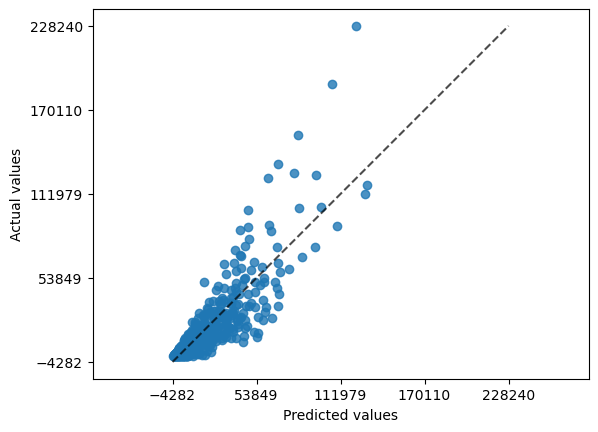

In [94]:
PredictionErrorDisplay.from_predictions( y_true= y_train, y_pred= reg_ridge.predict(X_train), 
                                        kind="actual_vs_predicted")

cette figure présente les valeurs prédites et la droite de regréssion. Elle fournit ainsi une explication visuelle aux erreur obtenues 

### Modélisation sur les données tronquées

In [47]:
base_t = base[base['cap_com']!=0]

In [48]:
base_t.shape

(81, 13)

In [49]:
base_t.columns

Index(['longueur', 'longueur_pond_hw', 'longueur_pond_adg', 'difference_hw',
       'difference_adg', 'cap_com', 'stat_com', 'surface', 'population',
       'log_long', 'log_lph', 'log_lpadg', 'long_surf'],
      dtype='object')

In [50]:
y= base_t['log_long']

In [51]:
data_t=base_t[['difference_hw','difference_adg', 'cap_com', 'surface', 'population','long_surf']]

#### Modelisation linéaire

In [52]:
model_lin= model = sm.OLS(y, sm.add_constant(data_t[['difference_hw','difference_adg', 'cap_com','surface', 'population','long_surf']])).fit()

In [53]:
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:               log_long   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     84.87
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           3.81e-31
Time:                        12:03:46   Log-Likelihood:                -6.6351
No. Observations:                  81   AIC:                             27.27
Df Residuals:                      74   BIC:                             44.03
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.0369      0.119     75.

Les résultats de a régréssion du logarithme de la longueur des aménagement cyclables montrent que le modèles est globalement significatif avec un pouvoir explicatif de plus de 86%. Au seuil de 5%, les variables explicatives de la longueur des aménagements sont : la surface de la commune, le ratio longueur/surface et la différence_adg. 
Pour une meilleure interprétation, il est primordial de vérifier les hypothèses du modèle.

### Vérification des hypothèses du modèle linéaire

In [54]:
# Évaluation de la validité de la spécification du modèle
reset_test = linear_reset(model_lin)
print('Test de Ramsey RESET pour la validité de la spécification du modèle :', reset_test)

Test de Ramsey RESET pour la validité de la spécification du modèle : <Wald test (chi2): statistic=27.33518060119716, p-value=1.1594204374366154e-06, df_denom=2>


##### Normalité des résidus 

In [55]:
residuals = model.resid

In [56]:
sw_test = shapiro(residuals)
print('Test de Shapiro-Wilk pour la normalité des résidus :', sw_test)

Test de Shapiro-Wilk pour la normalité des résidus : ShapiroResult(statistic=0.9512739181518555, pvalue=0.003797182347625494)


l'hypothèse de normalité des résidus n'est pas statistiquement vérifiée. Autrement dit, les données ne vérifie pas l'hypothèse selon laquelle les données sont issues d'une distribution normale.

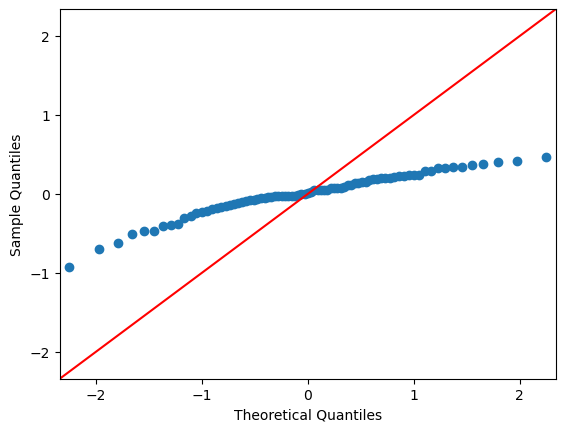

In [57]:
fig = sm.qqplot(residuals , line='45')

#### Prédiction

In [58]:
X_train, X_test, y_train, y_test = train_test_split( data_t, y, test_size=0.30, random_state=42)

In [59]:
def model(estimateur,normaliseur):
    model = Pipeline(
        steps=[ ("normaliseur", normaliseur), ("regressor", estimateur)]
    )

    return model

In [60]:
reg_lin= model(LinearRegression(),StandardScaler())

In [61]:
reg_lin.fit(X_train, y_train)
y_test_pred = reg_lin.predict(X_test)
y_train_pred = reg_lin.predict(X_train)

In [62]:
coef = reg_lin["regressor"].coef_
model_features=reg_lin.feature_names_in_
df_feature_importance = pd.DataFrame(coef, columns=["coef"], index=model_features)

In [63]:
df_feature_importance = pd.DataFrame(coef, columns=["coef"], index=model_features)

Text(0.5, 1.0, 'Regression linéaire')

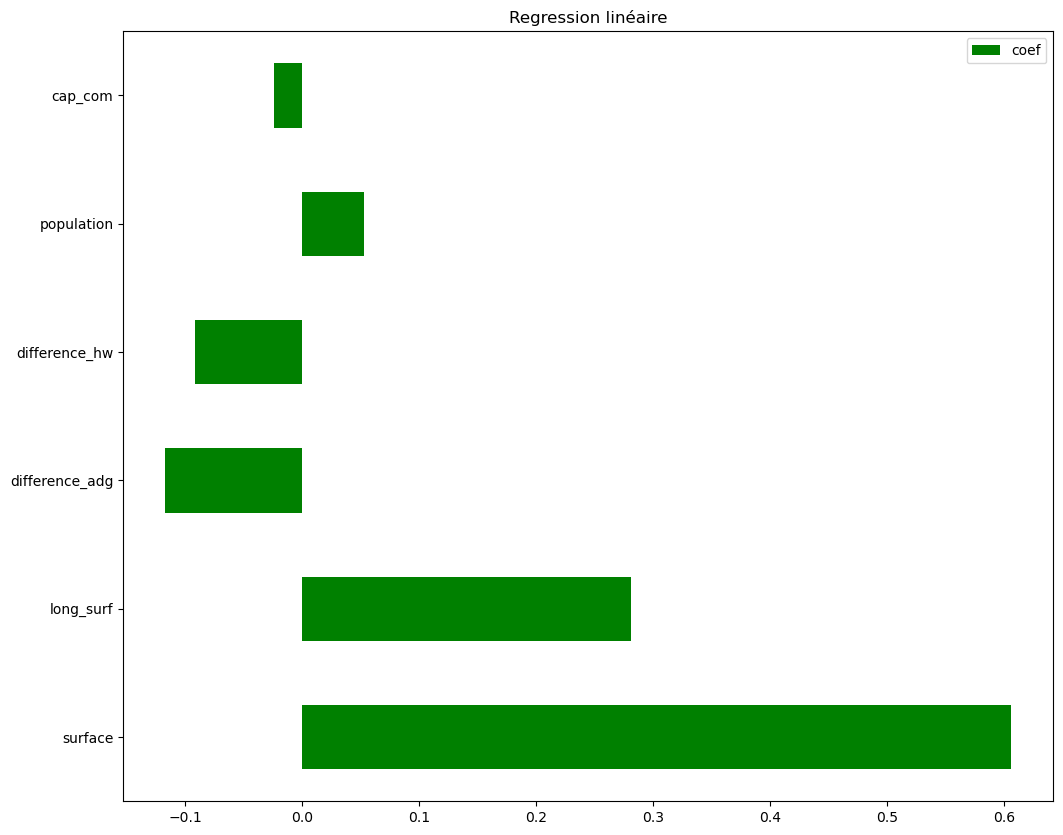

In [64]:
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=False)
 .head(40)
 .plot(kind="barh", figsize=(12, 10), color= 'green')
)
plt.title("Regression linéaire")

In [65]:
print(f"Model score - training data: {reg_lin.score(X_train, y_train)}")
print(f"Model score - test data: {reg_lin.score(X_test, y_test)}")

Model score - training data: 0.9090849703516779
Model score - test data: 0.7474929710496467


In [66]:
Bien que les estimateurs du modèles ne sont pas consistant, car ne vérifiant le hypothèses du modèle linéaire,
il semble avoir un bon pouvoir prédictif. Ceci peut être dû à la taille des données qui est très petites

SyntaxError: invalid syntax (609977435.py, line 1)

In [67]:
get_all_performances(value_train=(y_train, y_train_pred),
                     values_test=(y_test, y_test_pred),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,0.909085,0.747493
1,mean_squared_error,0.052174,0.120051
2,median_absolute_error,0.151147,0.152532
3,max_error,0.628483,1.152656


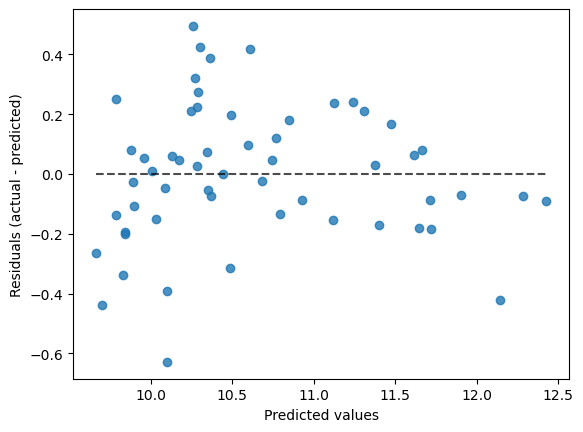

In [68]:
display = PredictionErrorDisplay(y_true=y_train, y_pred=y_train_pred)
display.plot()
plt.show()